
# Exercise Session 6: Shape From Stereo

One of the most common ways of reconstructing 3D shape from multiple images is called Shape-From-Stereo. It is based on the fact that points closer to the camera shift more in the image when the camera moves. By calculating the shift of each pixel we can deduce its relative distance to the camera.

For each pixel in one image we find the closest matching pixel in the other image using correlation between surrounding patches. We then compute the pixel distance between the matching points, which quantifies the disparity.

In this exercise we will implement those steps and test them with the below images

<img src="images/right.png">
<h1><center>Fig.1: Right image</center></h1>
<img src="images/left.png">
<h1><center>Fig.2: Left image</center></h1>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

* We start by reading left and right image. We convert them to greyscale and resize to speed up the computation. You don't have to change this code.

In [2]:
left_img = cv2.imread('images/left.png',0)
right_img = cv2.imread('images/right.png',0)
left_img = cv2.resize(left_img, None, fx=0.5, fy=0.5)
right_img = cv2.resize(right_img, None, fx=0.5, fy=0.5)

### Q1. Computing Normalized Cross Correlation

In order to compute the similarity between two pixels we can take a patch around the first pixel location, another patch around the second pixel location and compute normalized cross correlation between those two. The idea is that corresponding pixels should have similar neighbourhood and thus high cross correlation score.

* Implement a function ```score = NCC(patch1, patch2)``` that computes the normalized cross-correlation between two patches defined as:

\begin{equation}
NCC(p_1,p_2) = \frac{1}{N}( \sum_{0<=i<p_H,0<=j<p_W} \frac{(p_1(i,j)-\mu(p_1))*(p_2(i,j)-\mu(p_2))}{\sigma(p_1)*\sigma(p_2)})
\end{equation}

where $p_1$ and $p_2$ are compared patches of size $p_H \times p_W$, $N$ is the number of pixels in one patch and $\mu()$ and $\sigma()$ are mean and standard deviation of pixel intensities respecitvely. Hint: you can use ```np.mean()``` and ```np.std()``` functions.
#### Input parameters
- ```patch1 ``` : first patch
- ```patch2``` : second patch

#### Output
- ```score``` : normalized cross correlation score

In [9]:
def NCC(patch1,patch2):

    #Implement your function here
    W = patch1.shape[1]
    H = patch1.shape[0]
    N = W*H
    mean_p1 = np.mean(patch1)
    mean_p2 = np.mean(patch2)
    sd_p1 = np.std(patch1)
    sd_p2 = np.std(patch2)
    """
    sum=0
    for i in range(H) : 
        for j in range(W) :
            sum+= ((patch1[i,j]-mean_p1)*(patch2[i,j]-mean_p2))/(sd_p1*sd_p2)
    score = 1/N*sum
    """
    score =(1/N)*np.sum(((patch1-mean_p1)*(patch2-mean_p2))/(sd_p1*sd_p2))
    return score

In [10]:
#Let's test our function 
NCC(right_img,left_img)

0.18225081602161694

### Q2. Finding Best Matches and Computing The Disparity Map

A standard method for calculating the disparity map is to use a simple block matching. Essentially, for every pixel in the right image we’ll be taking a small region surrounding it (e.g. the yellow square in the figure below) and searching for the closest matching patch in the left image. The closest match is computed using normalized cross correlation implemented above. 

When searching in the left image, we’ll start at the same coordinates as our template patch from the right image and search $\textit{to the right up to some maximum distance}$ (since we know that camera shifted to the left) as depicted by the green rectangle in the figure below. The disparity is measured as the horizontal distance between the centers of the template patch in the right image and the closest matching patch (in our example the dashed yellow square) in the left image. We only need to search horizontally (along the rows) since the images are already rectified.

<img src="images/stereo.png">

* Implement a function ```disMap = PatchMatching(right_img, left_img, blockSize, disparityRange)``` that computes the disparity map using basic block matching as described above.
#### Input parameters
- ```right_img``` : the right image of size $H \times W$
- ```left_img ``` : the left image of size $H \times W$
- ```blockSize``` : the size of patch used for computing the normalized cross correlation score (patch is of size $blockSize \times blockSize$)
- ```disparityRange``` : the maximum horizontal distance (in this case to the right) we are going to search for the best machting patch. We recommend setting it to 30 to reduce the computation time. Hint: if the search range exceeds the image dimensions you can terminate the search earlier.

#### Output
- ```dispMap``` : the matrix storing the disparity values of size $H \times W$. You are free to decide the method for handling the boundaries.

In [11]:
def PatchMatching(right_img, left_img, blockSize, disparityRange = 30):
    
    # Implement your function here
    imgHeight, imgWidth = left_img.shape
    dispMap = np.zeros((imgHeight, imgWidth))
    halfBlockSize = blockSize // 2;
    for m in range(imgHeight):
        minr = max(0, m - halfBlockSize)
        maxr = min(imgHeight-1, m + halfBlockSize)
        for n in range(imgWidth):
            minc = max(0, n - halfBlockSize)
            maxc = min(imgWidth-1, n + halfBlockSize)
            mind = 0; 
            maxd = min(disparityRange, (imgWidth-1) - maxc)
            template = right_img[minr:maxr, minc:maxc]
            numBlocks = maxd - mind + 1;
            blockDiffs = np.zeros((numBlocks, 1))
            
            for i in range(mind, maxd+1):
                block = left_img[minr:maxr, (minc + i):(maxc + i)]
                blockIndex = i - mind
                blockDiffs[blockIndex, 0] = NCC(template, block) # 0.5PT *********

            bestMatchIndex = blockDiffs.argmax()
            d = bestMatchIndex + mind
            dispMap[m, n] = d
    return dispMap

### Q3. Visualization

* Visualize the disparity maps obtained using 7x7 and 15x15 patch sizes. Display also the colorbar (e.g. using ```plt.colorbar()```) to inspect the disparity values. It can take up to two minutes to compute each disparity map. 
* What is the trade-off of using bigger patches to compute NCC? Write your answer as a comment.

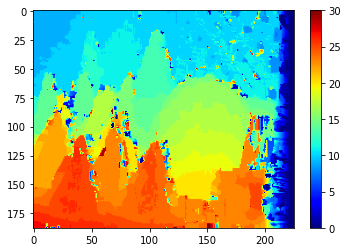

In [12]:
#Visualize the disparity map
dispmap = PatchMatching(right_img, left_img, 7)
plt.figure()
plt.imshow(dispmap, cmap='jet')
plt.colorbar()
plt.show()

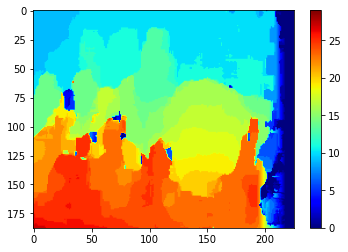

In [13]:
#Visualize the disparity map
dispmap = PatchMatching(right_img, left_img, 15)
plt.figure()
plt.imshow(dispmap, cmap='jet')
plt.colorbar()
plt.show()